In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import impute
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [2]:
# Read LFS data (after cleaning)
fn = "LFS_cleaned.tsv"
df = pd.read_csv(fn,sep="\t")

## Select Numeric Features

Calculate the correlation of numeric features to "Age_at_diagnosis"

In [3]:
feature_corr = df.corr()['Age_at_diagnosis']
feature_corr

Family_ID                    0.004567
Generations_analyzed         0.226798
MUT_ID                      -0.006318
hg18_Chr17_coordinates      -0.025699
hg19_Chr17_coordinates      -0.025700
hg38_Chr17_coordinates      -0.025701
Codon_number                -0.061515
REVEL                       -0.100563
BayesDel                    -0.086488
COSMIClink                   0.055529
CLINVARlink                  0.060734
cBioportalCount             -0.093932
Individual_ID                0.000555
Generation                  -0.311825
Dead                         0.057207
Unaffected                        NaN
Age                          0.957766
Tumor_ID                     0.000418
Age_at_diagnosis             1.000000
Ref_ID                       0.003699
p53mut_ID                    0.005343
Short_topo_combined_count   -0.059012
Name: Age_at_diagnosis, dtype: float64

Select features with |correlation| > 0.01

In [4]:
feature_with_high_corr = []

for feature, corr in feature_corr.iteritems():
    if abs(corr) > 0.01:
        feature_with_high_corr.append(feature)

feature_with_high_corr

['Generations_analyzed',
 'hg18_Chr17_coordinates',
 'hg19_Chr17_coordinates',
 'hg38_Chr17_coordinates',
 'Codon_number',
 'REVEL',
 'BayesDel',
 'COSMIClink',
 'CLINVARlink',
 'cBioportalCount',
 'Generation',
 'Dead',
 'Age',
 'Age_at_diagnosis',
 'Short_topo_combined_count']

Feature selection based on machine learning 

In [5]:
feature_to_remove = ['Generations_analyzed',
                     'hg18_Chr17_coordinates',
                     'hg19_Chr17_coordinates',
                     'hg38_Chr17_coordinates',
                     'Codon_number',
                     'COSMIClink',
                     'CLINVARlink',
                     'Generation',
                     'Dead',
                     'Age',
                     'Age_at_diagnosis']

In [6]:
selected_numeric_features = [f for f in feature_with_high_corr if f not in feature_to_remove]
selected_numeric_features

['REVEL', 'BayesDel', 'cBioportalCount', 'Short_topo_combined_count']

## Process Categorical Features

Categorical features that affect age of onset according to **"Feature studies - assess categorical variables.ipynb"**
* Short_topo_combined
* Residue_function
* Population
* Region
* DNEclass
* AGVGDClass
* SIFTClass
* Polyphen2

In [7]:
category_features = ['Short_topo_combined',
                     'Residue_function',  
                     'Population',
                     'Region',
                     'DNEclass',
                     'AGVGDClass',
                     'SIFTClass',  
                     'Polyphen2']

### Short_topo_combined - One Hot Encoding
* Keep common cancer types
* Combine rare cancer types (n<50) to 'Others'
* Apply One Hot Encoding

In [8]:
df['Short_topo_combined'].value_counts()

BREAST                            587
BRAIN                             317
SOFT TISSUES                      225
ADRENAL GLAND                     205
BONES (other)                     131
STOMACH                            74
HEMATOP. SYSTEM                    73
LUNG                               72
UNKNOWN SITE                       71
COLON                              40
PROSTATE                           34
OVARY                              27
COLORECTUM, NOS                    26
LIVER                              26
PANCREAS                           24
UTERUS                             19
SKIN                               19
LYMPH NODES                        17
BONES (limbs)                      17
KIDNEY                             16
TESTIS                             15
ESOPHAGUS                          11
NERVES                              9
THYROID                             9
CERVIX UTERI                        8
OTHER SITES                         7
PERITONEUM  

In [9]:
# Get list of common cancers (n >= 50)
common_tumors = [cancer for cancer, count in df['Short_topo_combined'].value_counts().iteritems() if count > 50]
common_tumors

['BREAST',
 'BRAIN',
 'SOFT TISSUES',
 'ADRENAL GLAND',
 'BONES (other)',
 'STOMACH',
 'HEMATOP. SYSTEM',
 'LUNG',
 'UNKNOWN SITE']

In [10]:
# convert least common tumor sites to "Others"
df['simplified_tumor'] = df.apply(lambda row: row['Short_topo_combined'] 
                                  if row['Short_topo_combined'] in common_tumors 
                                  else 'Others',axis=1)

In [11]:
# One Hot Encoding
df_cancer_onehot = pd.get_dummies(df, columns=["simplified_tumor"])
df_cancer_onehot.head()

,Family_ID,Family_code,Country,Population,Region,Development,Class,Generations_analyzed,Germline_mutation,MUT_ID,...,simplified_tumor_ADRENAL GLAND,simplified_tumor_BONES (other),simplified_tumor_BRAIN,simplified_tumor_BREAST,simplified_tumor_HEMATOP. SYSTEM,simplified_tumor_LUNG,simplified_tumor_Others,simplified_tumor_SOFT TISSUES,simplified_tumor_STOMACH,simplified_tumor_UNKNOWN SITE
0,4,Bard94,USA,Northern America,Americas,More developed regions,LFL,2.0,TP53,3259,...,0,0,0,0,1,0,0,0,0,0
1,4,Bard94,USA,Northern America,Americas,More developed regions,LFL,2.0,TP53,3259,...,0,0,0,0,0,0,1,0,0,0
2,4,Bard94,USA,Northern America,Americas,More developed regions,LFL,2.0,TP53,3259,...,1,0,0,0,0,0,0,0,0,0
3,5,Bir16,UK,Northern Europe,Europe,More developed regions,LFS,2.0,TP53,2821,...,0,0,0,1,0,0,0,0,0,0
4,5,Bir16,UK,Northern Europe,Europe,More developed regions,LFS,2.0,TP53,2821,...,1,0,0,0,0,0,0,0,0,0


In [12]:
onehot_feature = [col for col in df_cancer_onehot.columns.tolist() if col.startswith('simplified_tumor_')]
onehot_feature

['simplified_tumor_ADRENAL GLAND',
 'simplified_tumor_BONES (other)',
 'simplified_tumor_BRAIN',
 'simplified_tumor_BREAST',
 'simplified_tumor_HEMATOP. SYSTEM',
 'simplified_tumor_LUNG',
 'simplified_tumor_Others',
 'simplified_tumor_SOFT TISSUES',
 'simplified_tumor_STOMACH',
 'simplified_tumor_UNKNOWN SITE']

### Other categorical features
* Translated to valid numbers based on the ranking of average 'Age_at_diagnosis' 

In [13]:
# get other categorical features
category_features.remove('Short_topo_combined')

In [14]:
dict_feature_ranks = {}

for category_feature in category_features:
    df_age_mean = df.groupby(category_feature).agg({'Age_at_diagnosis':'mean'})
    feature_ordered = df_age_mean.sort_values(by='Age_at_diagnosis').index.to_list()
    dict_feature_ranks[category_feature] = dict(zip(feature_ordered,list(range(1, len(feature_ordered)+1))))

dict_feature_ranks

{'Residue_function': {'Ubiquitination site': 1,
  'Acetylation/Ubiquitination site': 2,
  'S-glutathionylation site': 3,
  'DNA binding': 4,
  'Tetramerisation/Methylation site': 5,
  'Zn binding': 6,
  'Buried': 7,
  'Partially exposed': 8,
  'Phosphorylation site': 9,
  'ADP-ribosylation': 10,
  'Exposed': 11,
  'Tetramerisation': 12,
  'Methylation site': 13,
  'Acetylation site': 14,
  'Acetylation/Methylation/Ubiquitination site': 15},
 'Population': {'Micronesia': 1,
  'More developed regions,NOS': 2,
  'Northern America': 3,
  'South America': 4,
  'Eastern Europe': 5,
  'South Eastern Asia': 6,
  'Eastern Asia': 7,
  'Northern Europe': 8,
  'Western Europe': 9,
  'Southern Europe': 10,
  'South Central Asia': 11,
  'Europe, NOS': 12,
  'Australia/New Zealand': 13,
  'Northern Africa': 14,
  'Western Asia': 15,
  'Central America': 16},
 'Region': {'More developed regions,NOS': 1,
  'Americas': 2,
  'Europe': 3,
  'Asia': 4,
  'Western Pacific': 5,
  'Africa': 6},
 'DNEclass': {

In [15]:
df_cancer_onehot.replace(dict_feature_ranks, inplace=True)
df_cancer_onehot.head()

,Family_ID,Family_code,Country,Population,Region,Development,Class,Generations_analyzed,Germline_mutation,MUT_ID,...,simplified_tumor_ADRENAL GLAND,simplified_tumor_BONES (other),simplified_tumor_BRAIN,simplified_tumor_BREAST,simplified_tumor_HEMATOP. SYSTEM,simplified_tumor_LUNG,simplified_tumor_Others,simplified_tumor_SOFT TISSUES,simplified_tumor_STOMACH,simplified_tumor_UNKNOWN SITE
0,4,Bard94,USA,3.0,2.0,More developed regions,LFL,2.0,TP53,3259,...,0,0,0,0,1,0,0,0,0,0
1,4,Bard94,USA,3.0,2.0,More developed regions,LFL,2.0,TP53,3259,...,0,0,0,0,0,0,1,0,0,0
2,4,Bard94,USA,3.0,2.0,More developed regions,LFL,2.0,TP53,3259,...,1,0,0,0,0,0,0,0,0,0
3,5,Bir16,UK,8.0,3.0,More developed regions,LFS,2.0,TP53,2821,...,0,0,0,1,0,0,0,0,0,0
4,5,Bir16,UK,8.0,3.0,More developed regions,LFS,2.0,TP53,2821,...,1,0,0,0,0,0,0,0,0,0


## Extract the selected features and create a new dataframe

In [16]:
feature_to_use = selected_numeric_features+category_features+onehot_feature

In [17]:
df_sel_features = df_cancer_onehot[feature_to_use]

In [18]:
df_sel_features.head()

,REVEL,BayesDel,cBioportalCount,Short_topo_combined_count,Residue_function,Population,Region,DNEclass,AGVGDClass,SIFTClass,...,simplified_tumor_ADRENAL GLAND,simplified_tumor_BONES (other),simplified_tumor_BRAIN,simplified_tumor_BREAST,simplified_tumor_HEMATOP. SYSTEM,simplified_tumor_LUNG,simplified_tumor_Others,simplified_tumor_SOFT TISSUES,simplified_tumor_STOMACH,simplified_tumor_UNKNOWN SITE
0,0.924,0.3710,23,1,7.0,3.0,2.0,1.0,7.0,1.0,...,0,0,0,0,1,0,0,0,0,0
1,0.924,0.3710,23,1,7.0,3.0,2.0,1.0,7.0,1.0,...,0,0,0,0,0,0,1,0,0,0
2,0.924,0.3710,23,1,7.0,3.0,2.0,1.0,7.0,1.0,...,1,0,0,0,0,0,0,0,0,0
3,0.936,0.5625,182,1,7.0,8.0,3.0,2.0,2.0,1.0,...,0,0,0,1,0,0,0,0,0,0
4,0.936,0.5625,182,1,7.0,8.0,3.0,2.0,2.0,1.0,...,1,0,0,0,0,0,0,0,0,0


In [19]:
X = df_sel_features.values
y = df_cancer_onehot['Age_at_diagnosis'].values

## Impute missing values
Replace missing values using the median along each column

In [20]:
# Count the number of nan for each feature
df_sel_features.isna().sum()

REVEL                               650
BayesDel                            650
cBioportalCount                       0
Short_topo_combined_count             0
Residue_function                    413
Population                           39
Region                               39
DNEclass                            858
AGVGDClass                          646
SIFTClass                           592
Polyphen2                           650
simplified_tumor_ADRENAL GLAND        0
simplified_tumor_BONES (other)        0
simplified_tumor_BRAIN                0
simplified_tumor_BREAST               0
simplified_tumor_HEMATOP. SYSTEM      0
simplified_tumor_LUNG                 0
simplified_tumor_Others               0
simplified_tumor_SOFT TISSUES         0
simplified_tumor_STOMACH              0
simplified_tumor_UNKNOWN SITE         0
dtype: int64

In [21]:
# Replace missing values with median
X_filledbymedian = impute.SimpleImputer(strategy='median').fit_transform(X)

## Build Machine Learning model 

In [22]:
r2 = []
fold = 10  # Set the number of fold for cross validation
kf = KFold(n_splits=fold,shuffle=True) 

df_importances = pd.DataFrame(columns=feature_to_use)
row = 0
for train_index, test_index in kf.split(X_filledbymedian):
    X_train, X_test = X_filledbymedian[train_index], X_filledbymedian[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    RF = RandomForestRegressor().fit(X_train, y_train)
    y_pred = RF.predict(X_test)
    r2.append(r2_score(y_test,y_pred))
    df_importances.loc[row] = RF.feature_importances_
    row+=1
    #importances.append(RF.feature_importances_)

C:\Users\TKHsu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\TKHsu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\TKHsu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\TKHsu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\TKHsu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

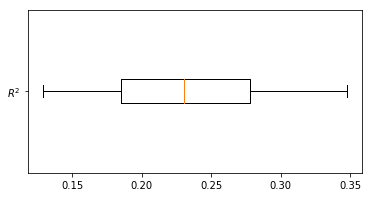

In [47]:
plt.figure(figsize=(6,3))
ax = plt.boxplot(r2,labels=['$R^{2}$'],vert=False)

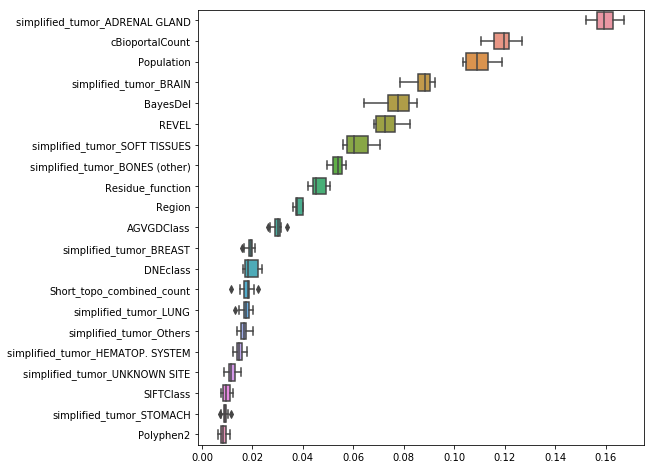

In [25]:
plt.figure(figsize=(8,8))
ax=sns.boxplot(data=df_importances,orient="h",order=df_importances.median().sort_values(ascending=False).index)

## Compare the $R^2$ before and after using most important features

In [36]:
# Extract the features with high importance
selected_features = df_importances.columns[df_importances.median()>0.03]

In [38]:
X_sel = df_sel_features[selected_features].values
X_sel_filledbymedian = impute.SimpleImputer(strategy='median').fit_transform(X_sel)

In [39]:
r2_sel = []

for train_index, test_index in kf.split(X_sel_filledbymedian):
    X_train, X_test = X_filledbymedian[train_index], X_filledbymedian[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    RF = RandomForestRegressor().fit(X_train, y_train)
    y_pred = RF.predict(X_test)
    r2_sel.append(r2_score(y_test,y_pred))


C:\Users\TKHsu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\TKHsu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\TKHsu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\TKHsu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\TKHsu\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

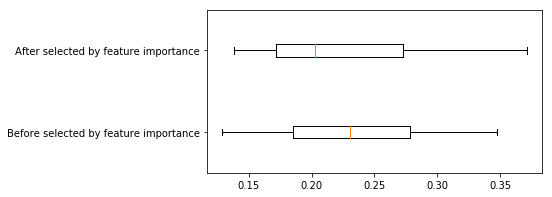

In [45]:
plt.figure(figsize=(6,3))
ax = plt.boxplot([r2,r2_sel],vert=False,labels=['Before selected by feature importance','After selected by feature importance'])